In [1]:
##### init model 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from os.path import isfile, join
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf   
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
# RUN_ENV='KATE'
RUN_ENV='GERRY'

In [3]:
### only need for colab. skip it if you run it in local

if RUN_ENV=='KATE':
    from google.colab import drive
    drive.mount('/content/drive')


In [4]:
### get physical GPU
if RUN_ENV=='GERRY':
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
EPOCHS=120

In [6]:
if RUN_ENV=='GERRY':
    data_dir='C:/Project 607_608/NewData'
elif RUN_ENV=='KATE':
    data_dir='/content/drive/MyDrive/facemask_detection_data/Mask_data_set_2'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

Found 9821 files belonging to 2 classes.
Using 7857 files for training.


In [7]:
import socket
import uuid
import sqlalchemy
def save_model_history_to_cloud(history,model_name):
    driver='mysql+mysqlconnector'
    username='admin'
    password='LuIboUmvFq1yobCGI9AQ'
    dbhost='datadb.ca0fpkbqdjfv.ca-central-1.rds.amazonaws.com'
    dbport='3306'
    dbname='dsdb'
    conn_string=driver+'://'+username+':'+password+'@'+dbhost+':'+dbport+'/'+dbname
    engine = sqlalchemy.create_engine(conn_string)
    model_data = pd.DataFrame.from_dict(history.history)
    model_data['machine']=socket.gethostname()
    model_data['total_epochs']=len(history.history['accuracy'])
    model_data['epochs']=model_data.index+1
    runid=str(uuid.uuid4())
    model_data['runid']=runid
    model_data['model_name']=model_name
    model_data.to_sql('model_data',engine, if_exists='append', chunksize=1000)
    return runid



In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                  data_dir,
                  validation_split=0.2,
                  subset="validation",
                  seed=123,
                  image_size=(IMG_HEIGHT, IMG_WIDTH),    
                  batch_size=BATCH_SIZE)

Found 9821 files belonging to 2 classes.
Using 1964 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['face_no_mask', 'face_with_mask']


In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break    


(32, 180, 180, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [13]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255,input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(2)
])

In [14]:
from tensorflow.keras.optimizers import Adam, SGD
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model.compile(optimizer=Adam(lr=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 128)      

In [16]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=EPOCHS,callbacks=[callback]

)

model.save('CNN.h5')

Epoch 1/120
246/246 [==============================] - 24s 33ms/step - loss: 0.3889 - accuracy: 0.8091 - val_loss: 0.2116 - val_accuracy: 0.9297
Epoch 2/120
246/246 [==============================] - 5s 22ms/step - loss: 0.2138 - accuracy: 0.9122 - val_loss: 0.1746 - val_accuracy: 0.9333
Epoch 3/120
246/246 [==============================] - 5s 21ms/step - loss: 0.1854 - accuracy: 0.9262 - val_loss: 0.1606 - val_accuracy: 0.9399
Epoch 4/120
246/246 [==============================] - 5s 21ms/step - loss: 0.1910 - accuracy: 0.9272 - val_loss: 0.1565 - val_accuracy: 0.9435
Epoch 5/120
246/246 [==============================] - 5s 21ms/step - loss: 0.1700 - accuracy: 0.9353 - val_loss: 0.1514 - val_accuracy: 0.9420
Epoch 6/120
246/246 [==============================] - 5s 21ms/step - loss: 0.1639 - accuracy: 0.9362 - val_loss: 0.1429 - val_accuracy: 0.9496
Epoch 7/120
246/246 [==============================] - 5s 21ms/step - loss: 0.1573 - accuracy: 0.9399 - val_loss: 0.1444 - val_accuracy

In [17]:
df=save_model_history_to_cloud(history,'ConvNet')

In [18]:
df

'26afc8ce-10e0-4229-89f7-526944022ae3'

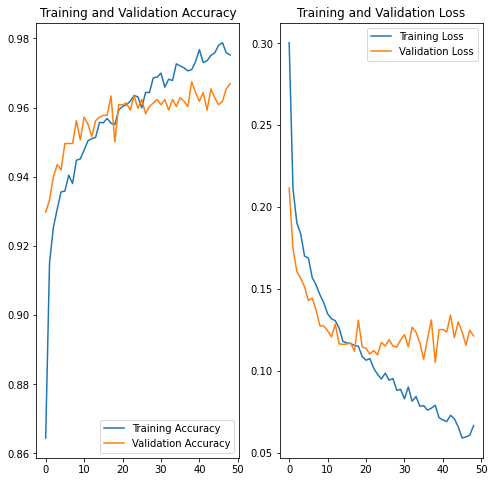

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

62/62 - 0s - loss: 0.1213 - accuracy: 0.9669


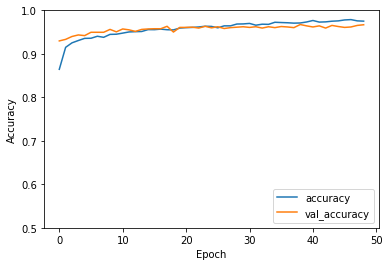

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(val_ds, verbose=2)

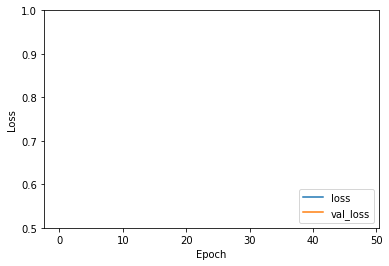

In [21]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

#test_loss, test_acc = model.evaluate(val_ds, verbose=2)

In [22]:
model.save("my_h5_model.h5")

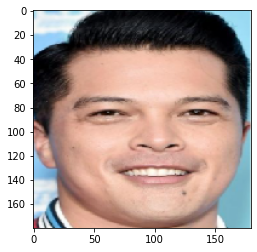

In [27]:
from tensorflow.keras.preprocessing import image

if RUN_ENV=='KATE':
    img_path = "/content/drive/MyDrive/facemask_detection_data/ai-faces-01.jpg"
elif RUN_ENV=='GERRY':
    img_path = "C:/Final/Sample/no_mask_4.png"
    
    

img = image.load_img(img_path, target_size=(180, 180))
plt.imshow(img)
plt.show()

In [28]:
img = image.load_img(img_path, target_size=(180, 180))

In [29]:
img_array = image.img_to_array(img)

# img_batch = np.expand_dims(img_array, axis=0)

img = np.reshape(img_array,[1, 180, 180, 3])

In [30]:
# img_preprocessed = preprocess_input(img_batch)

NameError: name 'img_batch' is not defined

In [31]:
prediction = model.predict(img)

In [32]:
print(prediction)

[[ 6.5212975 -3.9845011]]


In [33]:
classes = np.argmax(prediction, axis = 1)
print(classes)

[0]
